In [1]:
import os
import re
import sys
import yaml

from lightning import Trainer, seed_everything
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, matthews_corrcoef, confusion_matrix, roc_auc_score
import torch
import torch_geometric
from torch_geometric.nn import global_mean_pool, global_max_pool
import umap
import umap.plot as uplot

import CDPL.Pharm as Pharm
from dataset import PharmacophoreDataModule
from model import PhectorMatch
from utils import load_model_from_path
from virtual_screening import VirtualScreeningEmbedder, VirtualScreener, PharmacophoreAlignment

umap.plot.output_notebook()

/data/shared/software/conda/daniel_rose/envs/ph4/lib/python3.10/site-packages/flash/__init__.py:21: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/data/shared/software/conda/daniel_rose/envs/ph4/lib/python3.10/site-packages/flash/__init__.py:21: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):


Loading BokehJS ...

In [2]:
# Define global variables
PROJECT_ROOT = '/data/shared/projects/PhectorDB'
PRETRAINING_ROOT = f"{PROJECT_ROOT}/training_data"
VS_ROOT = f"{PROJECT_ROOT}/litpcba/ESR1_ant"
MODEL = PhectorMatch
VS_MODEL_NUMBER = 239
MODEL_PATH = f"{PROJECT_ROOT}/logs/{MODEL.__name__}/version_{VS_MODEL_NUMBER}/"
HPARAMS_FILE = "hparams.yaml"

params = yaml.load(
    open(os.path.join(PROJECT_ROOT, MODEL_PATH, HPARAMS_FILE), "r"), Loader=yaml.FullLoader
)

# Deterministic flags (should not be necessary for inference, but just in case)
torch.set_float32_matmul_precision("medium")
torch_geometric.seed_everything(params["seed"])
seed_everything(params["seed"])
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Setup datamodule
datamodule = PharmacophoreDataModule(
    PRETRAINING_ROOT,
    VS_ROOT,
    batch_size=params["batch_size"],
    small_set_size=params["num_samples"],
)
datamodule.setup()

# Load the model
model = load_model_from_path(os.path.join(PROJECT_ROOT, MODEL_PATH), MODEL)
device = [model.device.index]
trainer = Trainer(
    num_nodes=1,
    devices=[1],
    max_epochs=params["epochs"],
    accelerator="auto",
    logger=False,
    log_every_n_steps=2,
)

# Create embeddings of the VS dataset
embedder = VirtualScreeningEmbedder(model, datamodule, trainer)
screener = VirtualScreener(embedder)

Seed set to 42


Number of training graphs: 100000
Number of active graphs: 1311
Number of inactive graphs: 54585


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/data/shared/software/conda/daniel_rose/envs/ph4/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting: |          | 0/? [00:00<?, ?it/s]

Embedding time: 15.673392534255981
Matching calculation time: 0.02244091033935547


In [3]:
# Calculate alignment solution with CDPKit 
# You only need to run this once, the results are saved in the VS_ROOT
alignment = PharmacophoreAlignment(vs_root=VS_ROOT)
alignment.align_preprocessed_ligands_to_query()

Alignment of 1311 ph4s
Alignment took 0.4639 seconds
Alignment of 54585 ph4s
Alignment took 10.8308 seconds


--- Results for inactive molecules ---


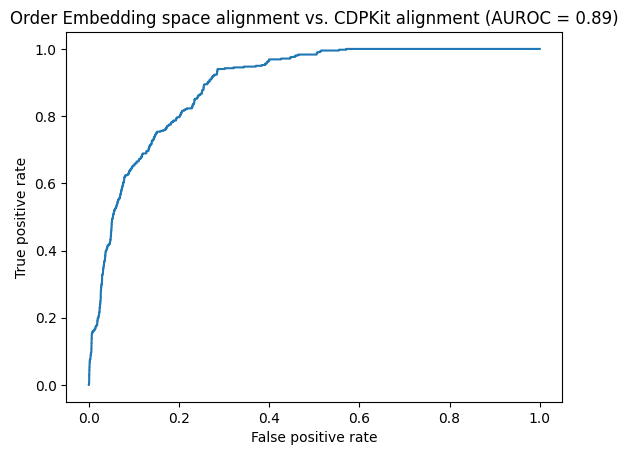

According to the ROC curve, the best threshold is 14.863383293151855.
----------------------------
This yields an MCC of 0.12572397097904098.
AUROC = 0.8949902671191512.
Confusion matrix:
[[38705 15462]
 [   25   393]]
----------------------------
Aggregation of conformational ensembles into one result per molecule:
This yields an MCC of 0.21056831108779833.
Confusion matrix:
[[2707 1053]
 [   1   71]]

--- Results for active molecules ---


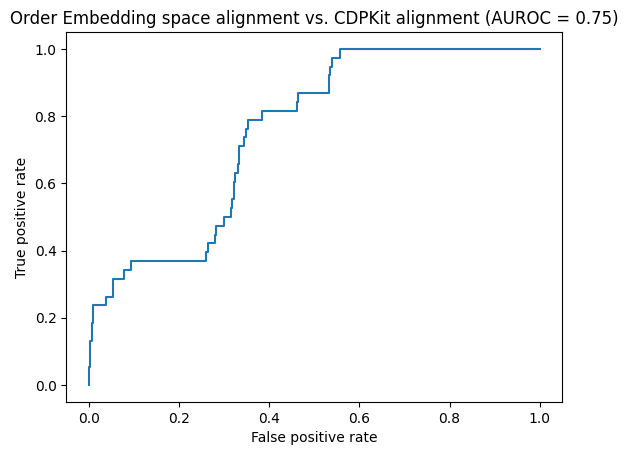

According to the ROC curve, the best threshold is 19.28823471069336.
----------------------------
This yields an MCC of 0.15036003102558473.
AUROC = 0.7526150411378013.
Confusion matrix:
[[565 708]
 [  0  38]]
----------------------------
Aggregation of conformational ensembles into one result per molecule:
This yields an MCC of 0.23040106009639746.
Confusion matrix:
[[37 45]
 [ 0  6]]

--- Results for the combination of both ---
According to the ROC curve, the best threshold is 14.863383293151855.
----------------------------
This yields an MCC of 0.1267007480461101.
AUROC = 0.8881561542745753.
Confusion matrix:
[[39453 15987]
 [   32   424]]
----------------------------
Aggregation of conformational ensembles into one result per molecule:
This yields an MCC of 0.21604843586186717.
Confusion matrix:
[[2761 1081]
 [   1   77]]


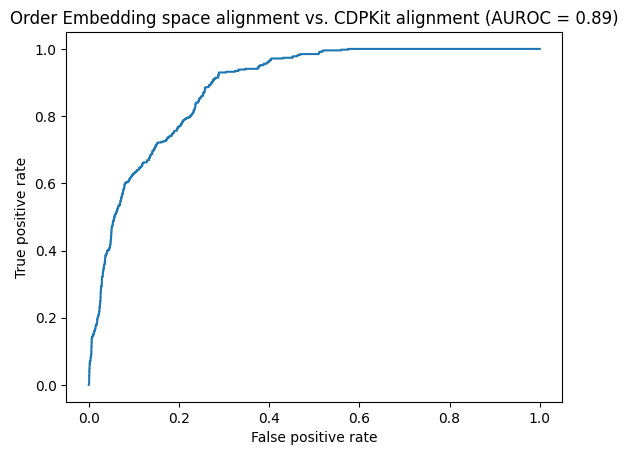

In [3]:
# Retrieve alignment score
active_alignment_score = torch.load(os.path.join(VS_ROOT, "vs/all_actives_aligned.pt"))
inactive_alignment_score = torch.load(os.path.join(VS_ROOT, "vs/all_inactives_aligned.pt"))
num_features_query = 5

def order_embedding_alignment_evaluation(order_embedding_score, cdp_kit_aligned_features, num_features_query, mol_ids, prefilter=None, path=None):
    # The alignment was successful if the number of aligned features matches the number of query features
    y_true = cdp_kit_aligned_features >= num_features_query
    y_pred = -order_embedding_score
    # Determine optimal threshold via ROC curve
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    auroc = roc_auc_score(y_true, y_pred)
    j = tpr - fpr
    idx = np.argmax(j)
    best_threshold = -threshold[idx]
    y_pred = order_embedding_score <= best_threshold
    
    if prefilter is not None:
        y_pred = y_pred * prefilter 

    # Results
    else:
        plt.plot(fpr, tpr)
        plt.title(f"Order Embedding space alignment vs. CDPKit alignment (AUROC = {auroc:.2f})")
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        if path:
            plt.savefig(path, dpi=300)
        else:
            plt.show()
    print(f"According to the ROC curve, the best threshold is {best_threshold}.")
    print("----------------------------")
    print(f"This yields an MCC of {matthews_corrcoef(y_true, y_pred)}.")
    print(f"AUROC = {auroc}.")
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))

    print("----------------------------")
    print("Aggregation of conformational ensembles into one result per molecule:")
    y_true = global_max_pool(y_true, mol_ids)
    y_pred = global_max_pool(y_pred, mol_ids)
    print(f"This yields an MCC of {matthews_corrcoef(y_true, y_pred)}.")
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))

print("--- Results for inactive molecules ---")
order_embedding_alignment_evaluation(screener.inactive_query_match, inactive_alignment_score[:, 0], num_features_query, screener.inactive_mol_ids)
print("\n--- Results for active molecules ---")
order_embedding_alignment_evaluation(screener.active_query_match, active_alignment_score[:, 0], num_features_query, screener.active_mol_ids)
print("\n--- Results for the combination of both ---")
order_embedding_alignment_evaluation(torch.cat((screener.active_query_match, screener.inactive_query_match)), torch.cat((active_alignment_score[:, 0], inactive_alignment_score[:, 0])), num_features_query, torch.cat((screener.active_mol_ids, screener.inactive_mol_ids + screener.active_mol_ids[-1] + 1)), path="alignment.png")

In [4]:
# Feature Count baseline - We need to get better than this
print("--- Feature count baseline for inactive ligands ---")
y_true = inactive_alignment_score[:, 0] >= num_features_query
y_pred = screener.inactives_prefilter_mask
print(f"MCC: {matthews_corrcoef(y_true, y_pred)}")
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nAfter aggregation of the conformational ensembles:")
y_true = global_max_pool(y_true, screener.inactive_mol_ids)
y_pred = global_max_pool(y_pred, screener.inactive_mol_ids)
print(f"MCC: {matthews_corrcoef(y_true, y_pred)}")
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

print("\n--- Feature count baseline for active ligands ---")
y_true = active_alignment_score[:, 0] >= num_features_query
y_pred = screener.actives_prefilter_mask
print(f"MCC: {matthews_corrcoef(y_true, y_pred)}")
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nAfter aggregation of the conformational ensembles:")
y_true = global_max_pool(y_true, screener.active_mol_ids)
y_pred = global_max_pool(y_pred, screener.active_mol_ids)
print(f"MCC: {matthews_corrcoef(y_true, y_pred)}")
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

--- Feature count baseline for inactive ligands ---
MCC: 0.09297622931773665
Confusion matrix:
[[28840 25327]
 [    0   418]]

After aggregation of the conformational ensembles:
MCC: 0.15653399678279778
Confusion matrix:
[[2151 1609]
 [   0   72]]

--- Feature count baseline for active ligands ---
MCC: 0.10528410917981781
Confusion matrix:
[[355 918]
 [  0  38]]

After aggregation of the conformational ensembles:
MCC: 0.17996401079640126
Confusion matrix:
[[27 55]
 [ 0  6]]


In [5]:
# We can also combine the prefilter with the order embedding alignment
print("--- Results for inactive molecules ---")
order_embedding_alignment_evaluation(screener.inactive_query_match, inactive_alignment_score[:, 0], num_features_query, screener.inactive_mol_ids, screener.inactives_prefilter_mask)
print("\n--- Results for active molecules ---")
order_embedding_alignment_evaluation(screener.active_query_match, active_alignment_score[:, 0], num_features_query, screener.active_mol_ids, screener.actives_prefilter_mask)

--- Results for inactive molecules ---
According to the ROC curve, the best threshold is 14.863383293151855.
----------------------------
This yields an MCC of 0.14945605022947575.
AUROC = 0.8949902671191512.
Confusion matrix:
[[42156 12011]
 [   25   393]]
----------------------------
Aggregation of conformational ensembles into one result per molecule:
This yields an MCC of 0.26636420024750995.
Confusion matrix:
[[3039  721]
 [   1   71]]

--- Results for active molecules ---
According to the ROC curve, the best threshold is 19.28823471069336.
----------------------------
This yields an MCC of 0.1774495037837886.
AUROC = 0.7526150411378013.
Confusion matrix:
[[673 600]
 [  0  38]]
----------------------------
Aggregation of conformational ensembles into one result per molecule:
This yields an MCC of 0.2767201141120194.
Confusion matrix:
[[45 37]
 [ 0  6]]


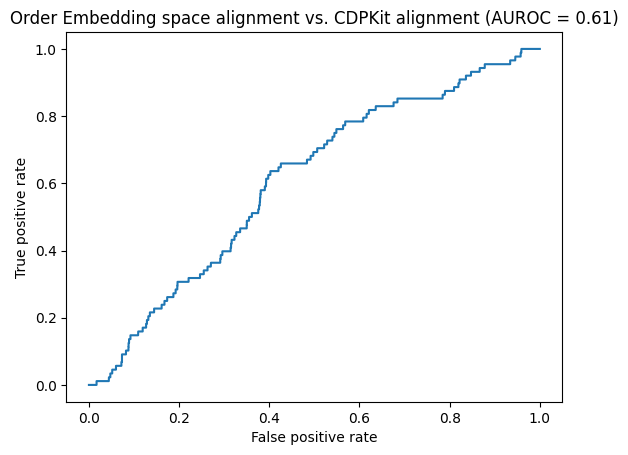

According to the ROC curve, the best threshold is 20.244609832763672.
----------------------------
This yields an MCC of 0.07053122124806367.
AUROC = 0.6078418580375784.
Confusion matrix:
[[2290 1542]
 [  32   56]]


In [6]:
order_embedding_score = -torch.cat((screener.active_query_match, screener.inactive_query_match))
mol_ids = torch.cat((screener.active_mol_ids, screener.inactive_mol_ids + screener.active_mol_ids[-1] + 1))
y_pred = global_max_pool(order_embedding_score, mol_ids)
y_true = torch.cat((torch.ones(screener.active_mol_ids[-1]+1), torch.zeros(screener.inactive_mol_ids[-1]+1)))
path="matching.png"  
fpr, tpr, threshold = roc_curve(y_true, y_pred)
auroc = roc_auc_score(y_true, y_pred)
j = tpr - fpr
idx = np.argmax(j)
best_threshold = -threshold[idx]
y_pred = -y_pred <= best_threshold

plt.plot(fpr, tpr)
plt.title(f"Order Embedding space alignment vs. CDPKit alignment (AUROC = {auroc:.2f})")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

print(f"According to the ROC curve, the best threshold is {best_threshold}.")
print("----------------------------")
print(f"This yields an MCC of {matthews_corrcoef(y_true, y_pred)}.")
print(f"AUROC = {auroc}.")
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

In [7]:
# First I train the UMAP on the latent space of the actives and inactives
# Only one representation per molecule, otherwise we get a distorted mapping
# This is why I fit to the mean representation of the conformations of each molecule
mean_actives = global_mean_pool(screener.active_embeddings, screener.active_mol_ids)
mean_inactives = global_mean_pool(screener.inactive_embeddings, screener.inactive_mol_ids)
reducer = umap.UMAP(metric="manhattan")
reducer.fit(torch.cat((mean_actives, mean_inactives)))
reduced_inactive_embeddings = reducer.transform(screener.inactive_embeddings)
reduced_active_embeddings = reducer.transform(screener.active_embeddings)
reduced_query_embedding = reducer.transform(screener.query_embedding)

In [3]:
# I want some hover data to explore the UMAP interactively, this is generated here
def getReaderByFileExt(filename: str) -> Pharm.PharmacophoreReader:
    name_and_ext = os.path.splitext(filename)

    if name_and_ext[1] == "":
        sys.exit(
            "Error: could not determine pharmacophore input file format (file extension missing)"
        )

    # get input handler for the format specified by the input file's extension
    ipt_handler = Pharm.PharmacophoreIOManager.getInputHandlerByFileExtension(
        name_and_ext[1][1:].lower()
    )

    if not ipt_handler:
        sys.exit(
            "Error: unsupported pharmacophore input file format '%s'"
            % name_and_ext[1]
        )

    # create and return file reader instance
    return ipt_handler.createReader(filename)

# Create dataframe for hover data
inactive_path = os.path.join(VS_ROOT, 'raw', 'inactives.psd')
active_path = os.path.join(VS_ROOT, 'raw', 'actives.psd') 
query_path = os.path.join(VS_ROOT, 'raw', 'query.pml')

def create_metadata(path):
    reader = getReaderByFileExt(path)
    ph4 = Pharm.BasicPharmacophore()
    names = []
    features = []
    index = []
    conf_index = []
    num_features = []
    conf = 0
    i = 0 
    name = ''

    while reader.read(ph4):
        if ph4.getNumFeatures() == 0:
            continue
        feature_types = Pharm.generateFeatureTypeHistogramString(ph4)
        if name == Pharm.getName(ph4):
            conf += 1
        else:
            conf = 0
            name = Pharm.getName(ph4)
        conf_index.append(conf)
        features.append(feature_types)
        names.append(name)
        index.append(i)
        num_features.append(ph4.getNumFeatures())
        i += 1

    metadata = pd.DataFrame({'index': index, 'name':names, 'conf_idx': conf_index, 'features': features, 'num_features': num_features})

    return metadata

inactive_metadata = create_metadata(inactive_path) 
active_metadata = create_metadata(active_path) 
query_metadata = create_metadata(query_path)

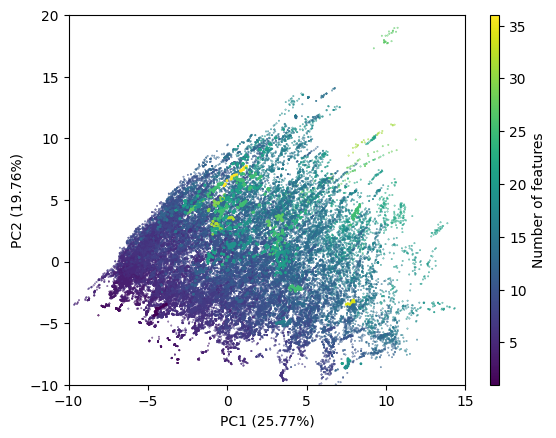

In [4]:
# PCA should conserve the order embedding space property
inactive_counts = inactive_metadata['num_features'].values
pca = PCA(n_components=4)
inactive_transformed = pca.fit_transform(screener.inactive_embeddings)
variance = pca.explained_variance_ratio_
plt.scatter(inactive_transformed[:, 0], inactive_transformed[:, 1], c=inactive_counts, cmap='viridis', s=0.1)
plt.xlabel(f"PC1 ({variance[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({variance[1]*100:.2f}%)")
cbar = plt.colorbar(aspect=40)
cbar.set_label("Number of features")
plt.xlim(-10, 15)
plt.ylim(-10, 20)
#plt.show()
plt.savefig("PCA_inactive.png", dpi=300)

# PCA should conserve the order embedding space property
active_counts = active_metadata['num_features'].values
active_transformed = pca.transform(screener.active_embeddings)
plt.xlabel(f"PC1 ({variance[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({variance[1]*100:.2f}%)")
plt.scatter(active_transformed[:, 0], active_transformed[:, 1], c=active_counts, cmap='viridis', s=1)
plt.show()

reduced_inactive_embeddings = pca.transform(screener.inactive_embeddings)
reduced_active_embeddings = pca.transform(screener.active_embeddings)
reduced_query_embedding = pca.transform(screener.query_embedding)

In [7]:
# This is the UMAP of the learned embedding space colored by the number of a specific or all features
def get_feature_count(feature, hover_data):
    feature_count = []
    count = 0
    for feature_string in hover_data['features']:
        if f'{feature}(' in feature_string:
            for str in feature_string.split(','):
                if f'{feature}(' in str:
                    count = int(re.findall(r'\d+', str)[0])
        else: 
            count = 0
        feature_count.append(count)

    return feature_count

In [5]:
# The interactive UMAP plot can't handle too much datapoints, so here we can reduce their number by some threshold 
max_num_inactives = 30000
hover_data = pd.concat((inactive_metadata[:max_num_inactives], active_metadata, query_metadata), ignore_index=True)
points = np.concatenate((reduced_inactive_embeddings[:max_num_inactives], reduced_active_embeddings, reduced_query_embedding))
labels = np.concatenate((np.zeros(len(reduced_inactive_embeddings[:max_num_inactives])), np.ones(len(reduced_active_embeddings)), np.ones(len(reduced_query_embedding))*2))
reducer.embedding_ = points

# This is the UMAP of the learned embedding space colored by the active/inactive/query status
p = uplot.interactive(reducer, labels=labels, theme='inferno', hover_data=hover_data, point_size=2)
umap.plot.show(p)

feature = 'AR'
feature_count = get_feature_count(feature, hover_data)
feature_count = hover_data['num_features'].values

p = uplot.interactive(reducer, values=feature_count, theme='darkblue', hover_data=hover_data, point_size=2)
umap.plot.show(p)

NameError: name 'reducer' is not defined

/tmp/ipykernel_53486/416422407.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  new_cmap = cm.get_cmap(cmap_str, 256)


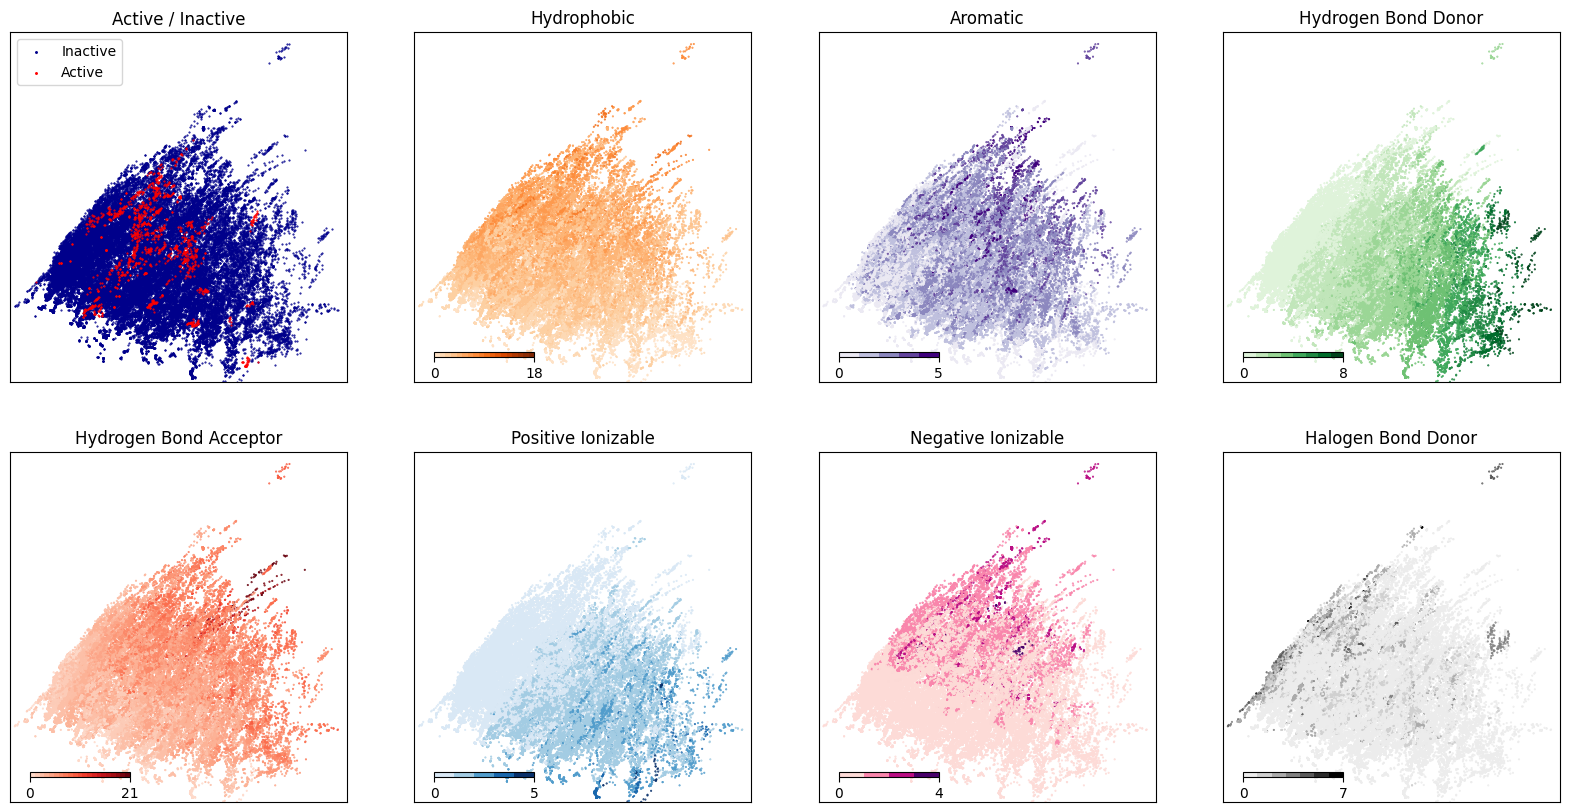

In [20]:
# The same plots, not interactive, but combined in one figure
max_num_inactives = -1
hover_data = pd.concat((inactive_metadata[:max_num_inactives], active_metadata, query_metadata), ignore_index=True)
points = np.concatenate((reduced_inactive_embeddings[:max_num_inactives], reduced_active_embeddings, reduced_query_embedding))

fig1, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)

# Plot actives and inactives
ax = axes[0][0]
sc = ax.scatter(reduced_inactive_embeddings[:, 0], reduced_inactive_embeddings[:, 1], c='darkblue', s=1, alpha=1, marker='.')
sc = ax.scatter(reduced_active_embeddings[:, 0], reduced_active_embeddings[:, 1], c='red', s=1, alpha=1, marker='.')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-10, 15)
ax.set_ylim(-10, 20)
ax.set_title('Active / Inactive')
ax.legend(['Inactive', 'Active'])
ax.legend_.legend_handles[0]._sizes = [5]
ax.legend_.legend_handles[1]._sizes = [5]

# Plot feature counts
features = {'H': 'Hydrophobic', 
            'AR': 'Aromatic',
            'HBD': 'Hydrogen Bond Donor', 
            'HBA': 'Hydrogen Bond Acceptor', 
            'PI': 'Positive Ionizable', 
            'NI': 'Negative Ionizable', 
            'XBD': 'Halogen Bond Donor'
            }
cmaps = ['Oranges', 'Purples', 'Greens', 'Reds', 'Blues', 'RdPu', 'Greys']

for ax, feature, cmap_str in zip(axes.flatten()[1:8], list(features.keys()), cmaps):
    feature_count = get_feature_count(feature, hover_data)
    new_cmap = cm.get_cmap(cmap_str, 256)
    cmap = ListedColormap(new_cmap(np.linspace(0.15, 1., max(feature_count))))
    sc = ax.scatter(points[:, 0], points[:, 1], c=feature_count, cmap=cmap, s=1, marker='.')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{features[feature]}')
    pos = ax.get_position()
    cax = plt.axes([pos.x0 + 0.01, pos.y0 + 0.025, 0.05, 0.005]) 
    cbar = plt.colorbar(sc, cax=cax, ticks=[0, max(feature_count)], location='bottom')
plt.savefig('embeddings.png', dpi=300, bbox_inches='tight')
